In [12]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import string
import random

from tqdm import tqdm

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
mpl.rcParams['lines.linewidth'] = 2

### Functions for generating the data

In [13]:
def generate_data(size, scheme, seed, a=5.0, b1=7.0, b2=14.0, c=0.0):
    """
    Generates data that serves as input to the function.
    Args:
        size: (int) the total number of data points
        scheme: (str) the nature of the generated data
        seed: (int) the number used to initialize random number generation
        a: (float) constant parameter
        b1: (float) time-varying parameter
        b2: (float) time-varying parameter

    Returns:
        (torch.tensor) values for a
        (torch.tensor) values for b
    """

    A = [a for i in range(size)]
    B = [b1 for i in range(size)]
    C = [c for i in range(size)]
    if scheme == "step":
        B = [b1 if i < size/2 else b2 for i in range(size)]
    elif scheme == "random":
        random.seed(seed)
        B = [float(random.uniform(b1, b2)) for i in range(size)]
    elif scheme == "alternate":
        B = [b1 if i % 2 == 0 else b2 for i in range(size)]
    elif scheme == "shift":
        C = [c if i < size / 2 else 5 for i in range(size)]
    elif scheme == "random_shift":
        random.seed(seed)
        B = [float(random.uniform(b1, b2)) for i in range(size)]
        C = [c if i < size / 2 else 5 for i in range(size)]

    return torch.tensor(np.array(A)), torch.tensor(np.array(B)), torch.tensor(np.array(C))


def cost(a, b, c, x):
    """
    the cost function
    Args:
        a, b, c: (torch.tensor) the parameters
        x: (torch.Parameter) the variable
    """

    return torch.log(a) + torch.log(torch.exp(-b * (x-c)) + torch.exp(b * (x-c)))

### Optimizers

In [14]:
def optimize_cost(n_iters, lr, x0, optimizer_name, a_vec, b_vec, c_vec,
                  decay=False, normalize=False):
    """
    optimizes the cost function
    """

    loss_values = []
    x = torch.tensor(x0, dtype=torch.float, requires_grad=True)
    x_values = [x.item()]
    optimizer = optim.Adagrad([x], lr=lr)
    if optimizer_name == "Adam":
        optimizer = optim.Adam([x], lr=lr)
    elif optimizer_name == "GD":
        optimizer = optim.SGD([x], lr=lr)
    for i in tqdm(range(n_iters)):
        if optimizer_name == "Adam":
            if i >= 1:
                optimizer.param_groups[0]['lr']=lr/np.sqrt(i)
        if decay:
            if i >= 1:
                optimizer.param_groups[0]['lr']=lr/np.sqrt(i)
        if normalize:
            optimizer.param_groups[0]['lr']=lr / (b_vec[i] ** 2)

        optimizer.zero_grad()
        loss = cost(a_vec[i], b_vec[i], c_vec[i], x)
        #print(loss)
        loss_values.append(loss.item())
        loss.backward()
        optimizer.step()
        x_values.append(optimizer.param_groups[0]['params'][0].item())

    ## the parameters and loss after the final update
    #loss = cost(a_vec[i], b_vec[i], c_vec[i], x)
    #loss_values.append(loss.item())
    #x_values.append(optimizer.param_groups[0]['params'][0].item())

    return np.array(loss_values) #, np.array(x_values)

def optimize_cost_ht(gamma, n_iters,x0, a_vec, b_vec, c_vec, mu=1):
    """
    optimizers the cost using higher order tuner
    """
    
    loss_values = []
    x_values = []
    x = torch.tensor(x0, dtype=torch.float, requires_grad=True)
    y = torch.tensor(x0, dtype=torch.float)
    z = torch.tensor(x0, dtype=torch.float)

    beta = 1 / gamma
    for i in tqdm(range(n_iters)):
        N_t = b_vec[i] ** 2
        alpha = mu / N_t
        eta = gamma / N_t
        x = beta * z + (1 - beta) * y
        x.requires_grad = True
        loss = cost(a_vec[i], b_vec[i], c_vec[i], x)
        loss_values.append(loss.item())
        loss.backward()
        with torch.no_grad():
            y = x - alpha * x.grad
            z = z - eta * x.grad

        x_values.append(x.item())
        x.grad = None

    #loss = cost(a_vec[i], b_vec[i], c_vec[i], x)
    #loss_values.append(loss.item())
    #x_values.append(x.item())

    return np.array(loss_values)#, np.array(x_values)

def optimize_cost_NAGD(n_iters, x0, a_vec, b_vec, c_vec, mu=1, gamma=1,
                       normalize=False):
    """
    optimizes the function using Nesterov's Accelerated Gradient Descent
    """

    loss_values = []
    x_values = []
    x = torch.tensor(x0, dtype=torch.float, requires_grad=True)
    y = torch.tensor(x0, dtype=torch.float)
    ## this corresponds to tilde z
    z = torch.tensor(x0, dtype=torch.float) * 2

    for i in tqdm(range(n_iters)):
        N_t = 1
        gamma = i / 2
        if normalize:
            N_t = b_vec[i] ** 2
            eta = gamma / N_t
        else:
            # assuming we are provided with normalized rate
            eta = gamma * mu
        alpha = mu / N_t

        beta = 2 / (i + 1)
        beta_next = 2 / (i + 2)
        x = z + (1 - beta) * y
        x.requires_grad = True
        loss = cost(a_vec[i], b_vec[i], c_vec[i], x)
        loss_values.append(loss.item())
        loss.backward()
        with torch.no_grad():
            y = x - alpha * x.grad.data
            z = beta_next / beta * z - beta_next * eta * x.grad.data

        x_values.append(x.item())
        x.grad = None

    return np.array(loss_values)#, np.array(x_values)

def optimize_cost_NAGD_beck(n_iters, x0, a_vec, b_vec, c_vec, mu=1,
                            normalize=False):
    """
    implements NAGD version by Beck and Tebouille
    """

    x = torch.tensor(x0, dtype=torch.float, requires_grad=True)
    y = torch.tensor(x0, dtype=torch.float, requires_grad=True)
    loss_values = []
    x_values = [x.item()]

    lambda_prev = 0
    for i in tqdm(range(n_iters)):
        lambda_s = (1 + np.sqrt(1 + 4 * (lambda_prev ** 2))) / 2
        lambda_next = (1 + np.sqrt(1 + 4 * (lambda_s ** 2))) / 2
        gamma_s = (1 - lambda_s) / lambda_next

        loss = cost(a_vec[i], b_vec[i], c_vec[i], x)
        loss_values.append(loss.item())
        loss.backward()
        N_t = 1
        if normalize:
            N_t = b_vec[i] ** 2
        alpha = mu / N_t
        with torch.no_grad():
            y_new = x - alpha * x.grad.data
            x = (1 - gamma_s) * y_new + gamma_s * y
            y = y_new

        x_values.append(x.item())
        x.requires_grad = True
        x.grad = None
        lambda_prev = lambda_s

    return loss_values #, x_values


def optimize_multiple_lr(lr_values, n_iters, x0, optimizer_name, a_vec, b_vec, c_vec,
                         plot=False):
    """
    selects the best learning rate
    """

    best_lr = 0
    lowest_error = np.inf
    all_loss = {}#np.zeros((len(lr_values), n_iters))
    for i in range(len(lr_values)):
        lr = lr_values[i]
        loss = optimize_cost(n_iters, lr, x0, optimizer_name, a_vec, b_vec,
                                c_vec)
        all_loss[lr] = loss
        if np.mean(loss ** 2) < lowest_error:
            lowest_error = np.mean(loss ** 2)
            best_lr = lr

    ## for debugging
    if plot:
        make_plot(np.arange(1, n_iters+1), all_loss, "t", r"$f_t(x)$",
                  f"Cost for {optimizer_name}")
    return best_lr


### Functions for plotting

In [15]:
COLOR_DICT = {"GD": "tab:blue", "Adam": "tab:green",
             "Adagrad":"tab:orange", "NAGD":"tab:red",
             "Normalized GD":"brown", "Normalized NAGD":"tab:pink",
              "HT": "black"}

def draw_axes(axes, data_dict, list_keys, x_label, y_label,
             axes_label=None, set_legend=True, linewidth=0.5):

    axes.set_xlabel(x_label)
    axes.set_ylabel(y_label)
    #print(data_dict)
    for key in list_keys:
        y_data = data_dict[key]
        x_data = np.arange(0, len(y_data))
        #print(x_data)
        axes.plot(x_data, y_data, linewidth=2, alpha=0.75, color=COLOR_DICT[key],
                 label=key)
        if axes_label is not None:
            axes.set_title(axes_label, loc="left", fontweight="bold")
        #    axes.text(0.05, 0.95, axes_label, transform=ax.transAxes,
      #fontsize=16, fontweight='bold', va='top')

    if set_legend:
        axes.legend()

def make_figure(data_dict, panel_a_opt, panel_b_opt, panel_c_opt,
               location="fig_output", name="figure.pdf",
               x_label="t", y_label=r"$f_t(x_t)$"):
    """
    makes the figures

    Args:
        data_dict: (str) optimizer name -> (np.ndarray) results
        panel_a_opt:(List[str])
        panel_b_opt:(List[str])
        panel_b_opt:(List[str])
    """

    fig = plt.figure(figsize=(14, 4))
    axes1 = fig.add_subplot(1, 3, 1)
    axes2 = fig.add_subplot(1, 3, 2)
    axes3 = fig.add_subplot(1, 3, 3)

    draw_axes(axes1, data_dict, panel_a_opt, x_label, y_label, "A")
    draw_axes(axes2, data_dict, panel_b_opt, x_label, y_label, "B")
    draw_axes(axes3, data_dict, panel_c_opt, x_label, y_label, "C")

    #path = Path(location)
    #path.mkdir(exist_ok=True, parents=True)
    #full_path = path / name

    #fig.savefig(full_path, bbox_inches="tight")

def make_plot(x, y_dict, x_label, y_label, title):

    fig = plt.figure()
    axes = fig.add_subplot(1, 1, 1)
    axes.set_xlabel(x_label)
    axes.set_ylabel(y_label)
    axes.set_title(title)

    for key in y_dict:
        axes.plot(x, y_dict[key], label=key)

    axes.legend()
    plt.tight_layout()
    #plt.close()

### Generate the data

In [16]:
N = 100
data_a_const, data_b_const, data_c_const = generate_data(N//2, "constant", 101,
                                                         a=5.0, b1=7.0)
data_a_step, data_b_step, data_c_step = generate_data(N, "step", 101, b1=7.0, b2=21.0)
data_a_shift, data_b_shift, data_c_shift = generate_data(N, "shift", 101)
data_a_rshift, data_b_rshift, data_c_rshift = generate_data(N, "random_shift", 101, b1=7.0, b2=10.0)

### Initialize values

In [17]:
start = 5
n_trials = 10
base_seed = 97

### Changing b from 7 to 21 halfway

In [18]:
adam_step_loss = np.zeros(N)
adagrad_step_loss = np.zeros(N)
ht_step_loss = np.zeros(N)
normalized_gd_step_loss = np.zeros(N)
normalized_nagd_step_loss = np.zeros(N)
gd_step_loss = np.zeros(N)
nagd_step_loss = np.zeros(N)

np.random.seed(base_seed)
start = random.uniform(5, 10)


for t in range(n_trials):
    random.seed((t+1) * base_seed)
    start = random.uniform(5, 10)
    best_lr_adam = optimize_multiple_lr([0.01, 0.05, 0.1, 0.5, 1, 2, 4], N//2, start,
                                    "Adam", data_a_const, data_b_const, data_c_const,
                                    plot=False)
    best_lr_adagrad = optimize_multiple_lr([0.01, 0.05, 0.1, 0.5, 1, 2, 4], N//2, start,
                                    "Adagrad", data_a_const, data_b_const, data_c_const,
                                    plot=False)
    adam_step_loss += optimize_cost(N, best_lr_adam, start, "Adam", data_a_step,
                                            data_b_step, data_c_step) / n_trials


    adagrad_step_loss += optimize_cost(N, best_lr_adagrad, start, "Adagrad", data_a_step,
                                            data_b_step, data_c_step) / n_trials

    ht_step_loss += optimize_cost_ht(1/0.67, N, start, data_a_step, data_b_step,
                                           data_c_step) / n_trials

    normalized_gd_step_loss += optimize_cost(N, 1, start, "GD", data_a_step,
                                            data_b_step, data_c_step, normalize=True) / n_trials
    normalized_nagd_step_loss += optimize_cost_NAGD(N, start, data_a_step, data_b_step,
                                                    data_c_step, normalize=True) / n_trials
    gd_step_loss += optimize_cost(N, 1/49, start, "GD", data_a_step,
                                data_b_step, data_c_step, normalize=False) / n_trials
    nagd_step_loss += optimize_cost_NAGD(N, start, data_a_step, data_b_step,
                                        data_c_step, mu=1/49, normalize=False) / n_trials

100%|██████████| 100/100 [00:00<00:00, 13825.25it/s]


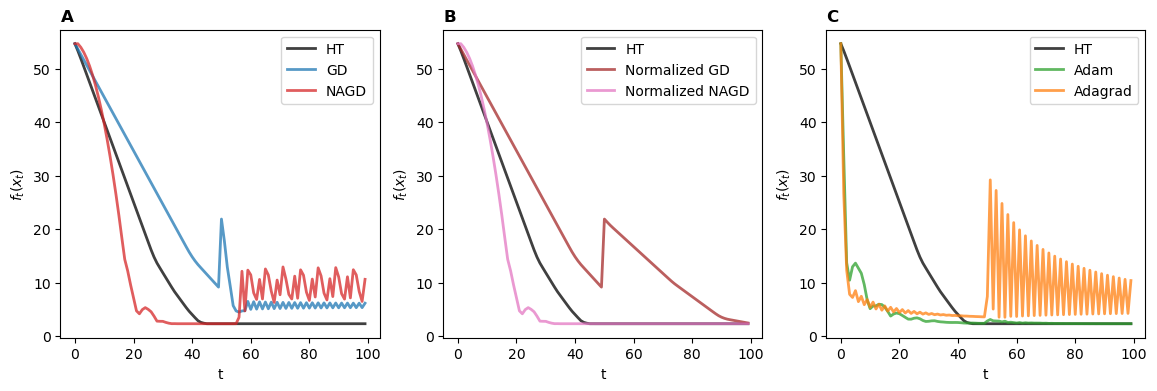

In [19]:
results_step = {"Normalized NAGD":normalized_nagd_step_loss, "Normalized GD": normalized_gd_step_loss,
             "GD": gd_step_loss, "HT": ht_step_loss, "NAGD":nagd_step_loss,
             "Adam": adam_step_loss, "Adagrad":adagrad_step_loss}
panel_a = ["HT", "GD", "NAGD"]
panel_b = ["HT", "Normalized GD", "Normalized NAGD"]
panel_c = ["HT", "Adam", "Adagrad"]
make_figure(results_step, panel_a, panel_b, panel_c, name="figure1.pdf")


### Changing the optimal from 0 to 5 halfway

In [20]:
adam_shift_loss = np.zeros(N)
adagrad_shift_loss = np.zeros(N)
ht_shift_loss = np.zeros(N)
normalized_gd_shift_loss = np.zeros(N)
normalized_nagd_shift_loss = np.zeros(N)
gd_shift_loss = np.zeros(N)
nagd_shift_loss = np.zeros(N)

np.random.seed(base_seed)
start = 5#random.uniform(5, 10)

for t in range(n_trials):
    random.seed((t+1) * base_seed)
    start = random.uniform(5, 10)
    adam_shift_loss += optimize_cost(N, best_lr_adam, start, "Adam", data_a_shift,
                                            data_b_shift, data_c_shift) / n_trials


    adagrad_shift_loss += optimize_cost(N, best_lr_adagrad, start, "Adagrad", data_a_shift,
                                            data_b_shift, data_c_shift) / n_trials

    ht_shift_loss += optimize_cost_ht(1/0.67, N, start, data_a_shift, data_b_shift,
                                           data_c_shift) / n_trials

    normalized_gd_shift_loss += optimize_cost(N, 1, start, "GD", data_a_shift,
                                            data_b_shift, data_c_shift, normalize=True) / n_trials
    normalized_nagd_shift_loss += optimize_cost_NAGD(N, start, data_a_shift, data_b_shift,
                                                    data_c_shift, normalize=True) / n_trials
    gd_shift_loss += optimize_cost(N, 1/49, start, "GD", data_a_shift,
                                data_b_shift, data_c_shift, normalize=False) / n_trials
    nagd_shift_loss += optimize_cost_NAGD(N, start, data_a_shift, data_b_shift,
                                        data_c_shift, mu=1/49, normalize=False) / n_trials

100%|██████████| 100/100 [00:00<00:00, 14330.68it/s]


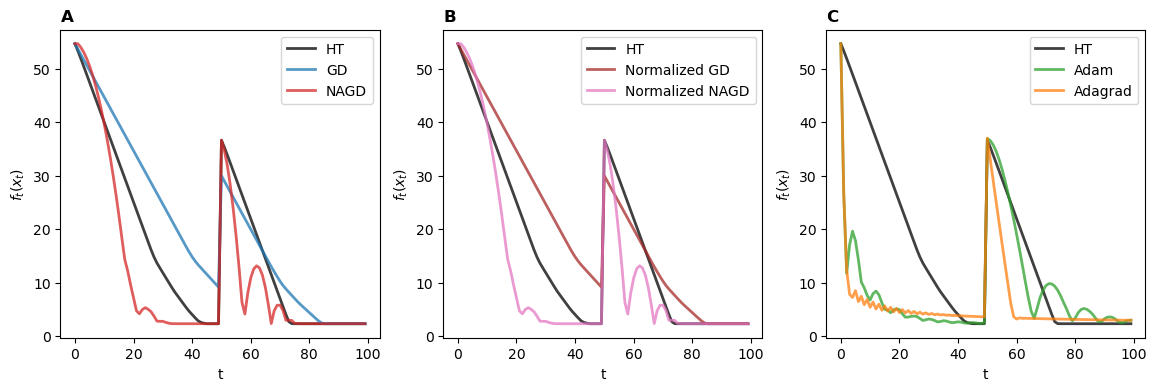

In [21]:
results_shift = {"Normalized NAGD":normalized_nagd_shift_loss, "Normalized GD": normalized_gd_shift_loss,
             "GD": gd_shift_loss, "HT": ht_shift_loss, "NAGD":nagd_shift_loss,
             "Adam": adam_shift_loss, "Adagrad":adagrad_shift_loss}
panel_a = ["HT", "GD", "NAGD"]
panel_b = ["HT", "Normalized GD", "Normalized NAGD"]
panel_c = ["HT", "Adam", "Adagrad"]
make_figure(results_shift, panel_a, panel_b, panel_c, name="figure1.pdf")

### Random b + Shifting the optimal

In [22]:
N = data_b_rshift.shape[0]
adam_rshift_loss = np.zeros(N)
adagrad_rshift_loss = np.zeros(N)
ht_rshift_loss = np.zeros(N)
normalized_gd_rshift_loss = np.zeros(N)
normalized_nagd_rshift_loss = np.zeros(N)
gd_rshift_loss = np.zeros(N)
nagd_rshift_loss = np.zeros(N)

np.random.seed(base_seed)
#start = 5#random.uniform(5, 10)
for t in range(10):
    random.seed((t+1) * base_seed)
    start = random.uniform(5, 10)
    best_lr_adam = optimize_multiple_lr([0.5, 1, 2, 4, 8], N, start,
                                    "Adam", data_a_rshift, data_b_rshift, data_c_rshift,
                                    plot=False)
    adam_rshift_loss += optimize_cost(N, best_lr_adam, start, "Adam", data_a_rshift,
                                            data_b_rshift, data_c_rshift) / n_trials
    best_lr_adagrad = optimize_multiple_lr([0.5, 1, 2, 4, 8], N, start,
                                    "Adagrad", data_a_rshift, data_b_rshift, data_c_rshift,
                                    plot=False)
    adagrad_rshift_loss += optimize_cost(N, best_lr_adagrad, start, "Adagrad", data_a_rshift,
                                            data_b_rshift, data_c_rshift) / n_trials

    ht_rshift_loss += optimize_cost_ht(1/0.67, N, start, data_a_rshift, data_b_rshift,
                                           data_c_rshift) / n_trials

    normalized_gd_rshift_loss += optimize_cost(N, 1, start, "GD", data_a_rshift,
                                            data_b_rshift, data_c_rshift, normalize=True) / n_trials
    normalized_nagd_rshift_loss += optimize_cost_NAGD(N, start, data_a_rshift, data_b_rshift,
                                                    data_c_rshift, normalize=True) / n_trials
    best_lr_gd = optimize_multiple_lr([0.01, 0.05, 0.1], N, start,
                                    "GD", data_a_rshift, data_b_rshift, data_c_rshift,
                                    plot=False)
    gd_rshift_loss += optimize_cost(N, best_lr_gd, start, "GD", data_a_rshift,
                                data_b_rshift, data_c_rshift, normalize=False) / n_trials
    nagd_rshift_loss += optimize_cost_NAGD(N, start, data_a_rshift, data_b_rshift,
                                        data_c_rshift, mu=1/49, normalize=False) / n_trials
    print("Best, Adam: {}, Adagrad: {}, GD:{}".format(best_lr_adam, best_lr_adagrad,
                                                      best_lr_gd))

100%|██████████| 100/100 [00:00<00:00, 12584.93it/s]


Best, Adam: 8, Adagrad: 4, GD:0.1


100%|██████████| 100/100 [00:00<00:00, 12481.19it/s]


Best, Adam: 4, Adagrad: 4, GD:0.1


100%|██████████| 100/100 [00:00<00:00, 13768.52it/s]


Best, Adam: 4, Adagrad: 4, GD:0.1


100%|██████████| 100/100 [00:00<00:00, 12780.89it/s]


Best, Adam: 4, Adagrad: 4, GD:0.1


100%|██████████| 100/100 [00:00<00:00, 14021.21it/s]


Best, Adam: 8, Adagrad: 4, GD:0.1


100%|██████████| 100/100 [00:00<00:00, 13330.06it/s]


Best, Adam: 8, Adagrad: 4, GD:0.1


100%|██████████| 100/100 [00:00<00:00, 13660.89it/s]


Best, Adam: 4, Adagrad: 8, GD:0.1


100%|██████████| 100/100 [00:00<00:00, 13060.26it/s]


Best, Adam: 8, Adagrad: 4, GD:0.1


100%|██████████| 100/100 [00:00<00:00, 14208.35it/s]


Best, Adam: 8, Adagrad: 4, GD:0.1


100%|██████████| 100/100 [00:00<00:00, 13015.68it/s]

Best, Adam: 4, Adagrad: 4, GD:0.1


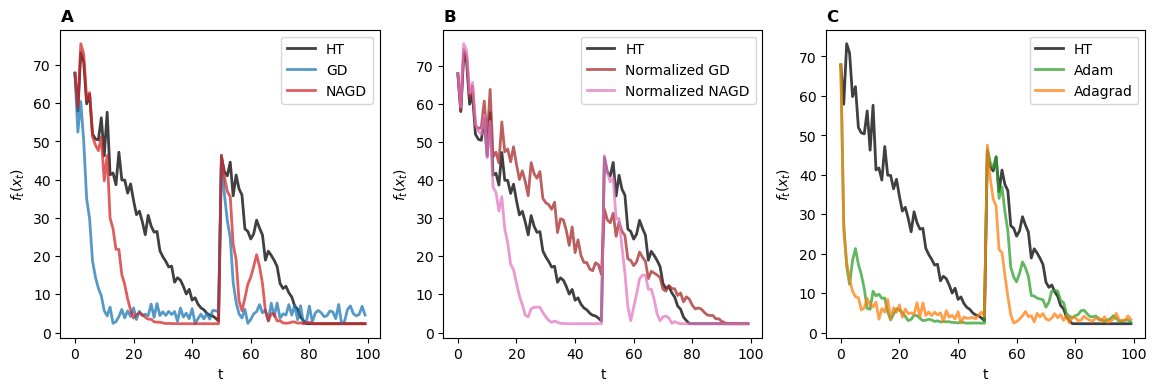

In [23]:
results_rshift = {"Normalized NAGD":normalized_nagd_rshift_loss,
                  "Normalized GD": normalized_gd_rshift_loss,
             "GD": gd_rshift_loss, "HT": ht_rshift_loss, "NAGD":nagd_rshift_loss,
             "Adam": adam_rshift_loss, "Adagrad":adagrad_rshift_loss}
panel_a = ["HT", "GD", "NAGD"]
panel_b = ["HT", "Normalized GD", "Normalized NAGD"]
panel_c = ["HT", "Adam", "Adagrad"]
make_figure(results_rshift, panel_a, panel_b, panel_c, name="figure1.pdf")